Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

import os

2024-07-15 15:50:03.939791: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-15 15:50:03.941474: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-15 15:50:03.987475: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-15 15:50:03.989410: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 15:50:04.628608: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Dataset Configuration

In [2]:
batch_size = 16


train_ds = tf.keras.utils.image_dataset_from_directory(
    os.getcwd() + '/Train',
    image_size=(128,128),
    batch_size=batch_size,
    label_mode = 'categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.getcwd() + '/Test',
    image_size=(128,128),
    batch_size=batch_size,
    label_mode = 'categorical'
)



Found 725 files belonging to 7 classes.
Found 207 files belonging to 7 classes.


2024-07-15 15:50:06.754020: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-15 15:50:06.754372: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
num_classes = len(train_ds.class_names)


Dataset Visualization

['Coffee', 'Corn', 'Eucalyptus', 'Goiaba', 'Orange', 'Soybean', 'Tomato']


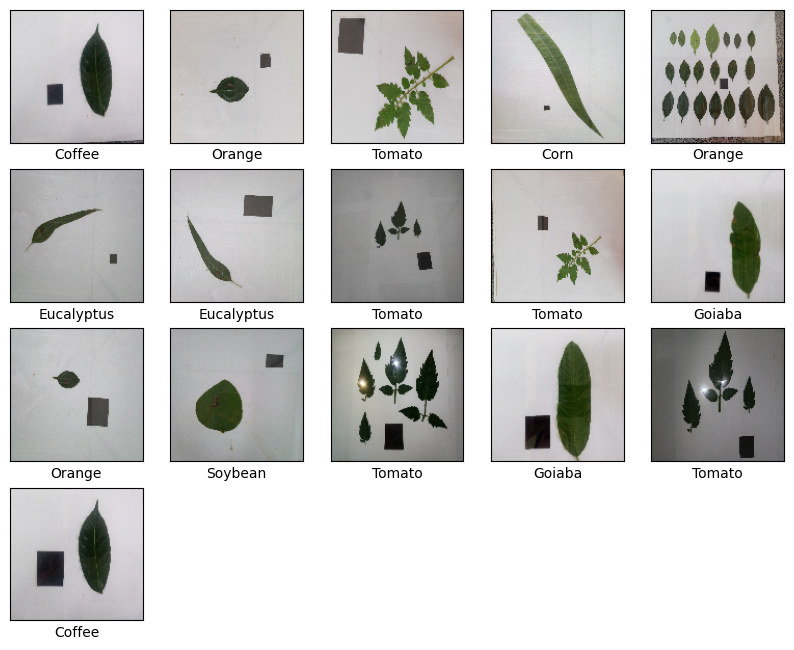

In [4]:
class_names = train_ds.class_names

print(class_names)

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(16):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.xlabel(class_names[tf.math.argmax(labels[i])])
  plt.show()

Normalizing Dataset

In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

Model

In [6]:
image_shape = (128, 128, 3)
# image_shape = (1920, 2560, 3)

# LeNet-5
lenet5 = Sequential([
            Conv2D(6, 5, activation='relu', input_shape=image_shape),
            MaxPooling2D(strides=(2,2)),
            Conv2D(16, 5, activation='relu'),
            MaxPooling2D(strides=(2,2)),
            Flatten(),
            Dense(120, activation='relu'),
            Dropout(0.5),
            Dense(84, activation='relu'),
            Dropout(0.5),
            Dense(7, activation='softmax')
])

# AlexNet
alex = Sequential([
            Conv2D(96, 11, strides=(4,4), activation='relu', input_shape=image_shape),
            MaxPooling2D(pool_size=(3,3), strides=(2,2)),
            Conv2D(256, 5, padding='same', activation='relu'),
            MaxPooling2D(pool_size=(3,3), strides=(2,2)),
            Conv2D(384, 3, padding='same', activation='relu'),
            Conv2D(384, 3, padding='same', activation='relu'),
            Conv2D(256, 3, padding='same', activation='relu'),
            MaxPooling2D(pool_size=(3,3), strides=(2,2)),
            Flatten(),
            Dense(4096, activation='relu'),
            Dropout(0.5),
            Dense(4096, activation='relu'),
            Dropout(0.5),
            Dense(7, activation='softmax')
])

# VGG-16
vgg16 = Sequential([
            Conv2D(64, 3, padding='same', activation='relu', input_shape=image_shape),
            Conv2D(64, 3, padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2,2), strides=(2,2)),
            Conv2D(128, 3, padding='same', activation='relu'),
            Conv2D(128, 3, padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2,2), strides=(2,2)),
            Conv2D(256, 3, padding='same', activation='relu'),
            Conv2D(256, 3, padding='same', activation='relu'),
            Conv2D(256, 3, padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2,2), strides=(2,2)),
            Conv2D(512, 3, padding='same', activation='relu'),
            Conv2D(512, 3, padding='same', activation='relu'),
            Conv2D(512, 3, padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2,2), strides=(2,2)),
            Conv2D(512, 3, padding='same', activation='relu'),
            Conv2D(512, 3, padding='same', activation='relu'),
            Conv2D(512, 3, padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2,2), strides=(2,2)),
            Flatten(),
            Dense(4096, activation='relu'),
            Dropout(0.5),
            Dense(4096, activation='relu'),
            Dropout(0.5),
            Dense(7, activation='softmax')
])

# Inception
inception = Sequential([
            Conv2D(64, 7, strides=(2,2), padding='same', activation='relu', input_shape=image_shape),
            MaxPooling2D(pool_size=(3,3), strides=(2,2)),
            Conv2D(64, 1, activation='relu'),
            Conv2D(192, 3, padding='same', activation='relu'),
            MaxPooling2D(pool_size=(3,3), strides=(2,2)),
            Conv2D(64, 1, activation='relu'),
            Conv2D(128, 3, padding='same', activation='relu'),
            Conv2D(256, 3, padding='same', activation='relu'),
            MaxPooling2D(pool_size=(3,3), strides=(2,2)),
            Conv2D(128, 1, activation='relu'),
            Conv2D(192, 3, padding='same', activation='relu'),
            Conv2D(256, 3, padding='same', activation='relu'),
            MaxPooling2D(pool_size=(3,3), strides=(2,2)),
            Conv2D(256, 1, activation='relu'),
            Conv2D(384, 3, padding='same', activation='relu'),
            Conv2D(256, 3, padding='same', activation='relu'),
            Conv2D(256, 3, padding='same', activation='relu'),
            MaxPooling2D(pool_size=(3,3), strides=(2,2)),
            Flatten(),
            Dense(4096, activation='relu'),
            Dropout(0.5),
            Dense(4096, activation='relu'),
            Dropout(0.5),
            Dense(7, activation='softmax')
])

In [7]:
model = alex

model.compile(optimizer=SGD(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 96)        34944     
                                                                 


 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 384)         885120    
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 384)         1327488   
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 6, 256)         884992    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 2, 2, 256)         0         
 g2D)     

TRAINING

In [8]:
history = model.fit(train_ds, epochs=15)

train_acc = history.history["accuracy"]
train_loss = history.history["loss"]


Epoch 1/15
46/46 [==============================] - 8s 137ms/step - loss: 3.3009 - accuracy: 0.1407
Epoch 2/15
46/46 [==============================] - 7s 134ms/step - loss: 1.9203 - accuracy: 0.1779
Epoch 3/15
46/46 [==============================] - 7s 142ms/step - loss: 1.9094 - accuracy: 0.2000
Epoch 4/15
46/46 [==============================] - 9s 162ms/step - loss: 1.9013 - accuracy: 0.2221
Epoch 5/15
46/46 [==============================] - 9s 170ms/step - loss: 1.8755 - accuracy: 0.2152
Epoch 6/15
46/46 [==============================] - 9s 173ms/step - loss: 1.8566 - accuracy: 0.2414
Epoch 7/15
46/46 [==============================] - 9s 173ms/step - loss: 1.8285 - accuracy: 0.2345
Epoch 8/15
46/46 [==============================] - 9s 172ms/step - loss: 1.8133 - accuracy: 0.2676
Epoch 9/15
46/46 [==============================] - 9s 175ms/step - loss: 1.7867 - accuracy: 0.2621
Epoch 10/15
46/46 [==============================] - 9s 177ms/step - loss: 1.7841 - accuracy: 0.2979

Testing

In [9]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)

print('\nTest accuracy:', test_acc)

13/13 [==============================] - 2s 58ms/step - loss: 1.5843 - accuracy: 0.3092

Test accuracy: 0.30917873978614807


Plotting

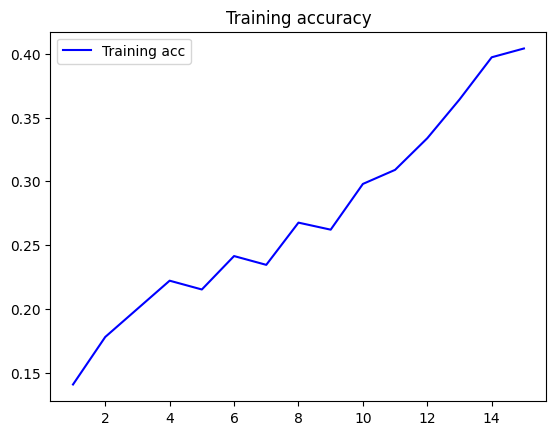

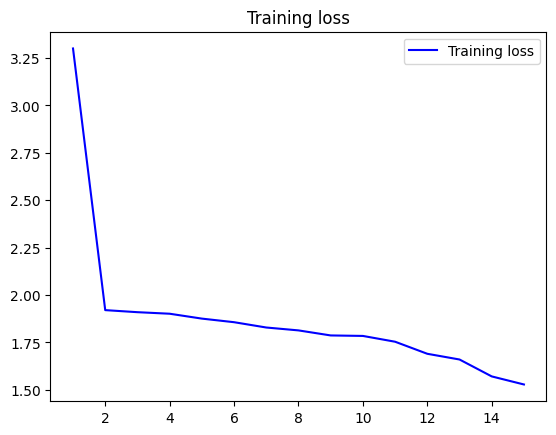

In [10]:
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

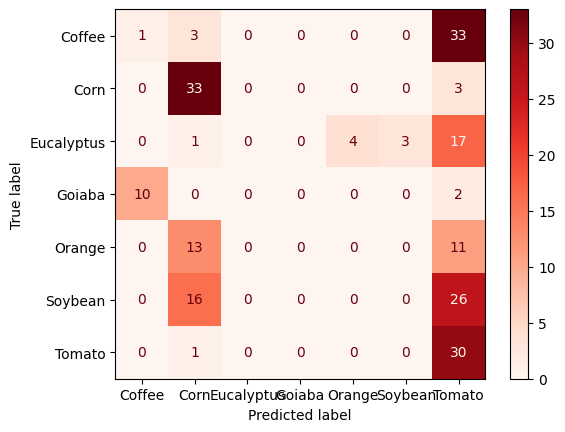

In [11]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

# predictions = probability_model.predict(test_ds)

predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x, verbose=0), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])


# confusion matrix
# confusion_matrix = metrics.confusion_matrix(test_ds, np.argmax(predictions, axis=1))
confusion_matrix = metrics.confusion_matrix(labels, predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=class_names).plot(cmap=plt.cm.Reds)